In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clawpack.pyclaw.solution as solution
from clawpack import riemann
import shallow_1D_redistribute_wave
%matplotlib inline

In [2]:
def wall_q(x, num_ghost):
    x_bc = np.zeros((x.shape[0], x.shape[1] + 2*num_ghost))
    x_bc[:,num_ghost:-num_ghost] = x
    x_bc[0,1] = x_bc[0,2]
    x_bc[1,1] = -x_bc[1,2]
    x_bc[:,0] = x_bc[:,1]
    x_bc[0,-2] = x_bc[0,-3]
    x_bc[1,-2] = -x_bc[1,-3]
    x_bc[:,-1] = x_bc[:,-2]
    
    return x_bc

def wall_aux(x, num_ghost):
    x_bc = np.zeros((x.shape[0], x.shape[1] + 2*num_ghost))
    x_bc[:,num_ghost:-num_ghost] = x
    x_bc[:,1] = x_bc[:,2]
    x_bc[:,0] = x_bc[:,1]
    x_bc[:,-2] = x_bc[:,-3]
    x_bc[:,-1] = x_bc[:,-2]
    
    return x_bc

def cfl_t(s,dx,cfl,LL,UL):
    sdx = 0.0
    for mw in range(s.shape[0]):
        smax1 = np.max(s[mw,LL-1:UL-1]/x_size)
        smax2 = np.max(-s[mw,LL-1:UL-1]/x_size)
        sdx = max(sdx,smax1,smax2)
        
    return cfl/sdx

def load_parameters(fileName):
    fileObj = open(fileName)
    params = {}
    for line in fileObj:
        line = line.strip()
        key_value = line.split('=')
        params[key_value[0]] = key_value[1]
    return params

In [3]:
params = load_parameters('parameters_h_box_wave.txt')
xlower = float(params['xlower'])
xupper = float(params['xupper'])
cells_number = int(params['cells_number'])
nw = int(params['wall_position']) # index of the edge used to present the wall
wall_height = float(params['wall_height'])
alpha = float(params['fraction'])

In [ ]:
dtdx = self.dt / (grid.delta[0] * aux[state.index_capa,:])
dtdx_hbox = np.zeros( (2*self.num_ghost+grid.num_cells[0]) )
                dtdx_hbox += self.dt / (grid.delta[0] * xpxc)
xpxc = cells_number * 1.0 / (cells_number-1)

In [4]:
problem_data = {}
problem_data['grav'] = 9.8
problem_data['sea_level'] = 0.0
problem_data['wall_position'] = nw
problem_data['wall_height'] = wall_height
problem_data['dry_tolerance'] = 0.001
problem_data['max_iteration'] = 1
problem_data['zero_width'] = True
problem_data['fraction'] = alpha
problem_data['arrival_state'] = False
dt = 0.1

In [ ]:
xpxc = cells_number * 1.0 / (cells_number-1)
dx = (xupper-xlower)/cells_number
dtdx = dt / (dx * aux_bc[1,:])
dtdx_hbox = np.zeros( (2*self.num_ghost+grid.num_cells[0]) )
                dtdx_hbox += self.dt / (grid.delta[0] * xpxc)

        

        wave,s,amdq,apdq,q_hbox_initial,aux_hbox = self.rp(q_l,q_r,aux_l,aux_r,state.problem_data)
                LL = self.num_ghost - 1
                UL = self.num_ghost + grid.num_cells[0] + 1

                # Update q for Godunov update
                iw = state.problem_data['wall_position'] + self.num_ghost - 1
                q_last = q[:,iw:iw+2].copy()

                for m in xrange(num_eqn):
                    q[m,LL:UL] -= dtdx[LL:UL]*apdq[m,LL-1:UL-1]
                    q[m,LL-1:UL-1] -= dtdx[LL-1:UL-1]*amdq[m,LL-1:UL-1]

                # check the arrivals
                q[:,iw:iw+2] = q_last[:,:] # reset the wall cells
                dt = self.dt
                num_waves = self.num_waves
                dx = grid.delta[0] * xpxc
                alpha = state.problem_data['fraction']
                arrival_times = np.array([0.0])
                for mw in xrange(num_waves):
                    if (s[mw,iw-1] > 0 and (s[mw,iw-1] * dt > alpha * dx)):
                        arrival_times = np.append(arrival_times, alpha * dx / s[mw,iw-1])
                    if (s[mw,iw+1] < 0 and ( (-s[mw,iw+1]) * dt > (1 - alpha) * dx ) ):
                        arrival_times = np.append(arrival_times, -(1 - alpha) * dx / s[mw,iw+1])
                arrival_times.sort()

                n_arrival_times = len(arrival_times)
                if n_arrival_times == 1 :
                    state.problem_data['arrival_state'] = False
                else:
                    state.problem_data['arrival_state'] = True
                    s_cells = np.zeros((num_waves, 3, n_arrival_times))
                    s_cells[:,:,0] = s[:, iw-1:iw+2].copy()
                    wave_cells = np.zeros((num_eqn, num_waves, 3, n_arrival_times))
                    wave_cells[:,:,:,0] = wave[:,:,iw-1:iw+2].copy()


                if state.problem_data['arrival_state'] == False:
                    q[:,iw] -= dt/(alpha * dx) * apdq[:,iw-1]
                    q[:,iw+1] -= dt/((1 - alpha)*dx) * amdq[:,iw+1]
                    for mw in xrange(num_waves):
                        if (s[mw,iw] < 0):
                            q[:,iw-1] -= dt/dx * ( max(0, -s[mw,iw] * dt - alpha * dx) / (-s[mw,iw] * dt) * wave[:,mw,iw] )
                            q[:,iw] -= dt/(alpha * dx) * (min(-s[mw,iw] * dt, alpha * dx) / (-s[mw,iw] * dt) * wave[:,mw,iw] )
                        elif (s[mw,iw] > 0):
                            q[:,iw+1] -= dt/((1 - alpha)*dx) * (min(s[mw,iw] * dt, (1 - alpha) * dx) / (s[mw,iw] * dt) * wave[:,mw,iw] )
                            q[:,iw+2] -= dt/dx * ( (max(0, s[mw,iw] * dt - (1 - alpha) * dx) /  s[mw,iw] * dt) * wave[:,mw,iw] )

                if state.problem_data['arrival_state'] == True:
                    ## update q_hbox
                    for i in xrange(1, n_arrival_times):
                        q_hbox = q_hbox_initial.copy()
                        for mw in xrange(num_waves):
                            if s[mw,iw-2] > 0:
                                q_hbox[:,0] -= arrival_times[i] / dx * (max(0, s[mw,iw-2] * arrival_times[i] - alpha * dx) / (s[mw,iw-2] * arrival_times[i]) * wave[:,mw,iw-2])

                            if s[mw, iw-1] < 0:
                                q_hbox[:,0] -= arrival_times[i] / dx * (min(-s[mw,iw-1] * arrival_times[i], (1 - alpha) * dx) / (-s[mw,iw-1] * arrival_times[i]) * wave[:,mw,iw-1])

                            if s_cells[mw,0,i] > 0:
                                for j in xrange(i):
                                    q_hbox[:,0] -= (arrival_times[j+1] - arrival_times[j]) / dx * (wave_cells[:,mw,0,j])

                                if s_cells[mw,0,i] * arrival_times[i] > alpha * dx - 1e-14:
                                    # check the arrival wave
                                    wave_cells[:,mw,0,i] = 0.0

                            if s_cells[mw,1,i] < 0:
                                for j in xrange(i):
                                    q_hbox[:,0] -= (arrival_times[i] - arrival_times[j]) / dx * (wave_cells[:,mw,1,j])

                            if s_cells[mw,1,i] > 0:
                                for j in xrange(i):
                                    q_hbox[:,1] -= (arrival_times[i] - arrival_times[j]) / dx * (wave_cells[:,mw,1,j])

                            if s_cells[mw,2,i] < 0:
                                for j in xrange(i):
                                    q_hbox[:,1] -= (arrival_times[j+1] - arrival_times[j]) / dx * (wave_cells[:,mw,2,j])

                                if (-s_cells[mw,2,i] * arrival_times[i]) > (1 - alpha) * dx - 1e-14:
                                    # check the arrival wave
                                    wave_cells[:,mw,2,i] = 0.0

                            if s[mw,iw+1] > 0:
                                q_hbox[:,1] -= arrival_times[i] / dx * (min(s[mw,iw+1] * arrival_times[i], alpha * dx) / (-s[mw,iw+1] * arrival_times[i]) * wave[:,mw,iw+1])

                            if s[mw,iw+2] < 0:
                                q_hbox[:,1] -= arrival_times[i] / dx * (max(0, -s[mw,iw+2] * arrival_times[i] - (1 - alpha) * dx) / (-s[mw,iw+2] * arrival_times[i]) * wave[:,mw,iw+2])

                        wave_cells[:,:,1,i],s_cells[:,1,i],amdq_arr,apdq_arr = self.rp(q_hbox[:,0],q_hbox[:,1],aux_hbox[:,0],aux_hbox[:,1],state.problem_data)

                    ## update q[iw-1], q[iw], q[iw+1] and q[iw+2]
                    arrival_times = np.append(arrival_times, dt)
                    n_arrival_times = len(arrival_times)

                    for mw in xrange(num_waves):
                        for i in xrange(n_arrival_times-1):
                            if s_cells[mw,0,i] > 0:
                                q[:,iw] -= (arrival_times[i+1] - arrival_times[i]) / (alpha * dx) * (wave_cells[:,mw,0,i])
                            if s_cells[mw,2,i] < 0:
                                q[:,iw+1] -= (arrival_times[i+1] - arrival_times[i]) / ((1 - alpha) * dx) * (wave_cells[:,mw,2,i])
                            if s_cells[mw,1,i] < 0:
                                q[:,iw-1] -= (dt - arrival_times[i]) / dx * ( max(0, -s_cells[mw,1,i] * (dt - arrival_times[i]) - alpha * dx) / (-s_cells[mw,1,i] * (dt - arrival_times[i])) * wave_cells[:,mw,1,i] )
                                q[:,iw] -= (dt - arrival_times[i]) / (alpha * dx) * ( min(-s_cells[mw,1, i] * (dt - arrival_times[i]), alpha * dx) / (-s_cells[mw,1,i] * (dt - arrival_times[i])) * wave_cells[:,mw,1,i] )
                            if s_cells[mw,1,i] > 0:
                                q[:,iw+1] -= (dt - arrival_times[i]) / ((1 - alpha) * dx) * ( min(s_cells[mw,1, i] * (dt - arrival_times[i]), (1 - alpha) * dx) / (s_cells[mw,1,i] * (dt - arrival_times[i])) * wave_cells[:,mw,1,i] )
                                q[:,iw+2] -= (dt - arrival_times[i]) / dx * ( max(0, s_cells[mw,1,i] * (dt - arrival_times[i]) - (1- alpha) * dx) / (s_cells[mw,1,i] * (dt - arrival_times[i])) * wave_cells[:,mw,1,i] )


            cfl = 0.0
                for mw in xrange(wave.shape[1]):
                    smax1 = np.max(dtdx_hbox[LL:UL]*s[mw,LL-1:UL-1])
                    smax2 = np.max(-dtdx_hbox[LL-1:UL-1]*s[mw,LL-1:UL-1])
                    cfl = max(cfl,smax1,smax2)
                    
        self.cfl.update_global_max(cfl)
        state.set_q_from_qbc(num_ghost,self.qbc)
        if state.num_aux > 0:
            state.set_aux_from_auxbc(num_ghost,self.auxbc)



In [5]:
error_h= []
num_eqn = 2
num_waves = 2
num_ghost = 2

xpxc = cells_number * 1.0 / (cells_number-1)

t_final = 3
cfl = 0.8

iw = nw + num_ghost - 1
aux_initial = np.zeros((2,cells_number))
aux_initial[0,:] = np.ones((1, cells_number))*(-0.8)
aux_initial[1,:] = xpxc
aux_initial[1,nw-1] *=alpha
aux_initial[1,nw] *= (1-alpha)

q_initial = np.zeros((num_eqn, cells_number))
q_initial[0,:] = 0.0 - aux_initial[0,:]
q_initial[0,:] = q_initial[0,:].clip(min=0)
q_initial[0,:nw-5] += 0.4
q_initial[1,:] = 0.0

q = q_initial.copy()
aux = aux_initial.copy()

x_size = (xupper-xlower)/cells_number
    
dx = np.ones(cells_number + 2*num_ghost)*x_size
dx_error = dx.copy()
dx_error[iw] *= alpha
dx_error[iw+1] *= 1-alpha

LL = num_ghost - 1
UL = num_ghost + cells_number + 1

q_bc = wall_q(q, num_ghost)
aux_bc = wall_aux(aux, num_ghost)
q_l = q_bc[:,:-1].copy()
q_r = q_bc[:,1:].copy()
aux_l = aux_bc[:,:-1].copy()
aux_r = aux_bc[:,1:].copy()

wave,s,amdq,apdq = shallow_1D_redistribute_wave.shallow_fwave_hbox_dry_1d(q_l, q_r, aux_l.copy(), aux_r.copy(), problem_data)

dt = cfl_t(s,x_size,cfl,LL,UL)
dtdx = dt/dx
t_next = 0.0
t_next += dt
t_steps = [0.0]
t_steps.append(dt)


while t_next < t_final:
    
    for m in range(num_eqn):
        q_bc[m,LL:UL] -= dtdx[LL:UL]*(apdq[m,LL-1:UL-1])
        q_bc[m,LL-1:UL-1] -= dtdx[LL-1:UL-1]*(amdq[m,LL-1:UL-1])
    q = q_bc[:,num_ghost:-num_ghost]
    error_h.append((sum(q[0,:]*dx_error[num_ghost:-num_ghost]) - sum(q_initial[0,:]*dx_error[num_ghost:-num_ghost]))/sum(q_initial[0,:]*dx_error[num_ghost:-num_ghost]))
    
    # calucate the data for next update
    q_bc = wall_q(q, num_ghost)
    q_l = q_bc[:,:-1].copy()
    q_r = q_bc[:,1:].copy()

    wave,s,amdq,apdq = shallow_1D_redistribute_wave.shallow_fwave_hbox_dry_1d(q_l, q_r, aux_l.copy(), aux_r.copy(), problem_data)
    dt = cfl_t(s,x_size,cfl,LL,UL)
    t_next += dt
    t_steps.append(t_next)
    dtdx = dt/dx
    print(dtdx)
dt = t_final - (t_next - dt)
t_steps[-1] = t_final
dtdx = dt/dx
for m in range(num_eqn):
    q_bc[m,LL:UL] -= dtdx[LL:UL]*(apdq[m,LL-1:UL-1])
    q_bc[m,LL-1:UL-1] -= dtdx[LL-1:UL-1]*(amdq[m,LL-1:UL-1])
q = q_bc[:,num_ghost:-num_ghost]  

error_h.append((sum(q[0,:]*dx_error[num_ghost:-num_ghost]) - sum(q_initial[0,:]*dx_error[num_ghost:-num_ghost]))/sum(q_initial[0,:]*dx_error[num_ghost:-num_ghost]))


[0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507
 0.21770507 0.21770507 0.21770507 0.21770507 0.21770507 0.2177

[0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137 0.2151137
 0.215

[0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331
 0.21801331 0.21801331 0.21801331 0.21801331 0.21801331 0.2180

[0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053
 0.22070053 0.22070053 0.22070053 0.22070053 0.22070053 0.2207

[0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566
 0.22977566 0.22977566 0.22977566 0.22977566 0.22977566 0.2297

[0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108
 0.22978108 0.22978108 0.22978108 0.22978108 0.22978108 0.2297

[0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201
 0.23185201 0.23185201 0.23185201 0.23185201 0.23185201 0.2318

[0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963
 0.23892963 0.23892963 0.23892963 0.23892963 0.23892963 0.2389

[0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241
 0.23290241 0.23290241 0.23290241 0.23290241 0.23290241 0.2329

[0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017
 0.23324017 0.23324017 0.23324017 0.23324017 0.23324017 0.2332

[0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037
 0.23376037 0.23376037 0.23376037 0.23376037 0.23376037 0.2337

[0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877
 0.23975877 0.23975877 0.23975877 0.23975877 0.23975877 0.2397

[0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824
 0.23704824 0.23704824 0.23704824 0.23704824 0.23704824 0.2370

[0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058
 0.23727058 0.23727058 0.23727058 0.23727058 0.23727058 0.2372

[0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481
 0.24278481 0.24278481 0.24278481 0.24278481 0.24278481 0.2427

[0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198
 0.23773198 0.23773198 0.23773198 0.23773198 0.23773198 0.2377

[0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177 0.2380177
 0.238

[0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784
 0.24189784 0.24189784 0.24189784 0.24189784 0.24189784 0.2418

[0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501
 0.23914501 0.23914501 0.23914501 0.23914501 0.23914501 0.2391

[0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425
 0.23950425 0.23950425 0.23950425 0.23950425 0.23950425 0.2395

[0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217
 0.23984217 0.23984217 0.23984217 0.23984217 0.23984217 0.2398

[0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073
 0.23952073 0.23952073 0.23952073 0.23952073 0.23952073 0.2395

[0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501
 0.24333501 0.24333501 0.24333501 0.24333501 0.24333501 0.2433

[0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777
 0.24002777 0.24002777 0.24002777 0.24002777 0.24002777 0.2400

[0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018
 0.24057018 0.24057018 0.24057018 0.24057018 0.24057018 0.2405

[0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464
 0.24053464 0.24053464 0.24053464 0.24053464 0.24053464 0.2405

[0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894
 0.24028894 0.24028894 0.24028894 0.24028894 0.24028894 0.2402

[0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299
 0.24341299 0.24341299 0.24341299 0.24341299 0.24341299 0.2434

[0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726
 0.24051726 0.24051726 0.24051726 0.24051726 0.24051726 0.2405

[0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405
 0.24187405 0.24187405 0.24187405 0.24187405 0.24187405 0.2418

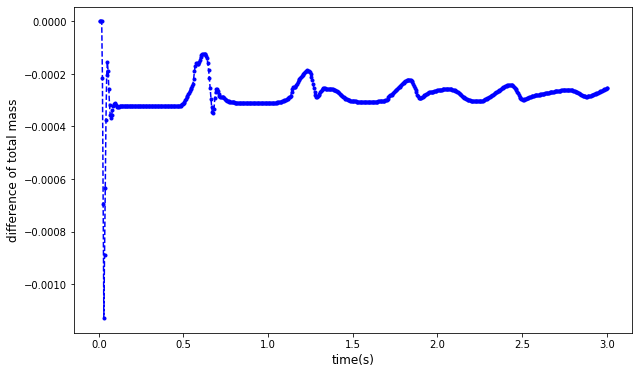

In [6]:
fig = plt.figure(figsize=(10,6))

plt.plot(t_steps[1:], error_h, 'b--.')

# plt.title("Comparison of Errors for h")
plt.xlabel("time(s)", fontsize=12)
plt.ylabel("difference of total mass", fontsize=12)
# plt.ylabel("$\sum h(t) - \sum h(0)$")
#plt.ylim([-2e-15,1e-15])
plt.show()
fig.savefig('mass_conservation.pdf')

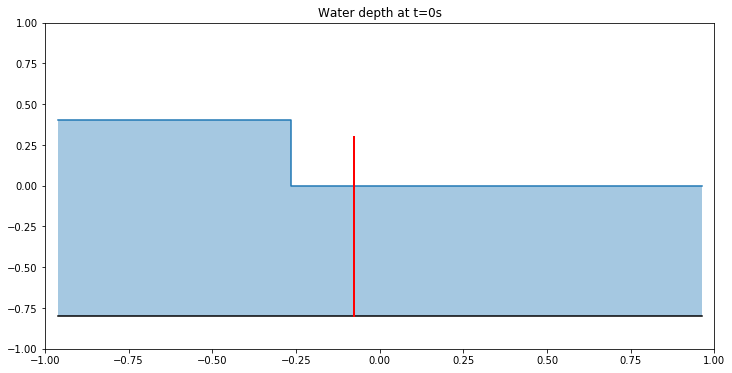

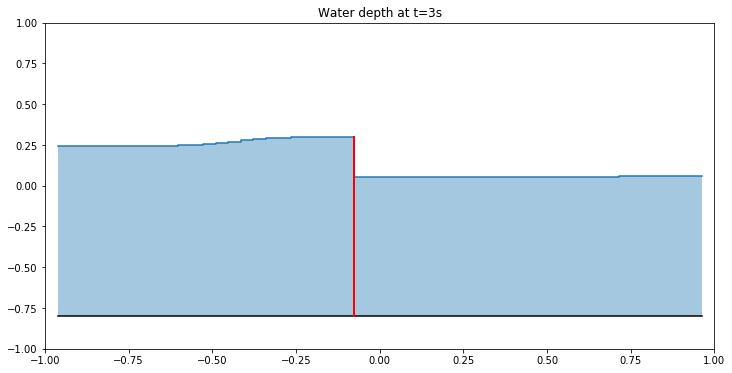

In [12]:
xc = np.linspace(xlower+x_size, xupper-x_size, len(q_initial[0,:]))
plt.figure(figsize=(12,6))
plt.fill_between(xc, q_initial[0,:]+aux_initial[0,:],y2=aux_initial[0,:], step="mid", alpha=0.4)
plt.step(xc, q_initial[0,:]+aux_initial[0,:], where='mid')
plt.step(xc, aux_initial[0,:], 'k', where='mid')
x_wall = nw*x_size+xlower
y1 = 0.5*(aux_initial[0,nw-1] + aux_initial[0,nw])
y2 = y1 + wall_height
plt.plot([x_wall,x_wall],[y1,y2],'r',linewidth=2)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Water depth at t=0s")
plt.show()

plt.figure(figsize=(12,6))
plt.fill_between(xc, q[0,:]+aux_initial[0,:],y2=aux_initial[0,:], step="mid", alpha=0.4)
plt.step(xc, q[0,:]+aux_initial[0,:], where='mid')
plt.step(xc, aux_initial[0,:], 'k', where='mid')
x_wall = nw*x_size+xlower
y1 = 0.5*(aux_initial[0,nw-1] + aux_initial[0,nw])
y2 = y1 + wall_height
plt.plot([x_wall,x_wall],[y1,y2],'r',linewidth=2)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Water depth at t="+ str(t_final)+"s")
plt.show()